## Assignment 2:

The goal is to compare `dense neural networks` and `convolutional neural networks` on `Fashion mnist` data.



In all the experiments, we would hold some parameters constants - the batch size to 100, the number of epochs to 20, same optimizer, same loss function of cross entropy, so that we can do fair comparisons. 



* EXPERIMENT 1: DNN with 2 layers (no drop out)

* EXPERIMENT 2: DNN with 3 layers (no drop out)

* **EXPERIMENT 3: CNN with 2 convolution/max pooling layers (no drop out)**

* **EXPERIMENT 4: CNN with 3 convolution/max pooling layers (no drop out)**

* EXPERIMENT 5: Redo all the 4 experiments with 20% drop out

`Result1`:  Create a table with the accuracy and loss for train/test/validation & process time for all the 8 models

`Result2`: Take `EXPERIMENT 3` – Extract the outputs from 2 selected filters from the 2 max pooling layers and visualize them in a grid as images. See whether the 'lit up' regions correspond to some features in the original images.

## Import packages needed (and set seed)

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
keras.__version__

'2.2.4-tf'

In [ ]:
tf.__version__

In [2]:
# To get consistint results each time we rerun the code.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

## The Fashion MNIST dataset

Zalando is Europe's leading online fashion platform for women, men and children. `Fashion-MNIST` is a dataset of their product images. Just like `MNIST` dataset, the `Fashion-MNIST` also consists of 70,000 grayscale images of 28x28 pixels divided into 60,000 training images and 10,000 test images. Each image is labeled with with an integer from 0 to 9 representing 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', respectively. `Fashion-MNIST` is intended to serve as a direct drop-in replacement for the original `MNIST` dataset for benchmarking machine learning algorithms since the the original `MNIST` was found to be too easy for the current machine learning models. In particular, Fashion-Mist shares the same image size and structure of training and testing splits as `MNIST`. Also like `MNIST` it comes prepackaged in `tf.Keras`. Use

```python
fashion_mnist.load_data()
```

to the get these datasets (and the corresponding labels) as Numpy arrays. See the `Fashion-MNIST` GitHub page for a lot more information about the data sets and benchmarks for 129 classifiers trained on the data:

https://github.com/zalandoresearch/fashion-mnist

In [3]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

## EXPERIMENT 3

We create a `CNN` with 2 convolution/max pooling layers (**no drop out**) to work with our Fashion MNIST dataset.

## Preparing the data

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the \[0, 1] interval.

Our training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 

We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the [0, 1] interval.

Currently, our training images are stored in an array of shape (60000, 28, 28). Each image is represented by a 28x28 array of uint8 values in the range [0, 255]. 

We transform it into a float32 array of shape (60000, 28, 28, 1) with values between 0 and 1.

In [4]:
# We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1. 

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

## Validating our approach

We set apart 5,000 samples of our training data to use as a validation set. Since we will be using `sparse_categorical_crossentropy` as the loss function we **do not** need to use `to_categorical` to convert the class vector of labels to binary matrix representation.

In [5]:
# Create validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Building our network

We build a `CNN` containing 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes.

In [6]:
# CNN with 2 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

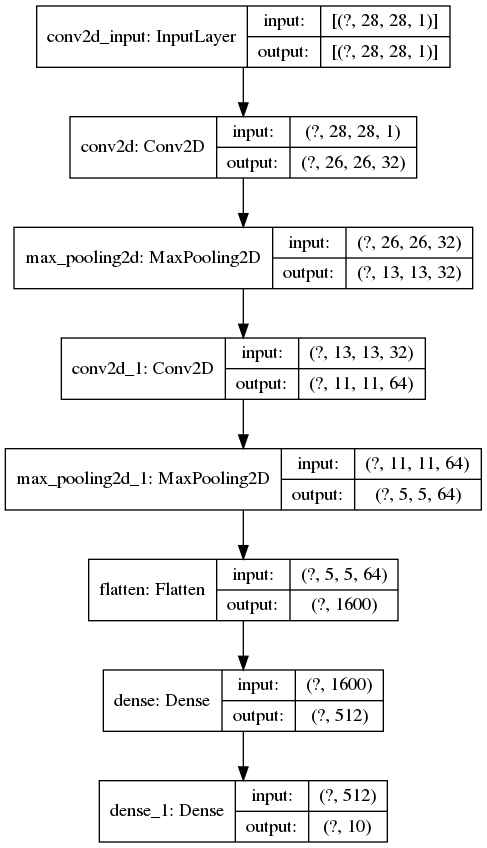

In [7]:
keras.utils.plot_model(model, show_shapes=True)

## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [8]:
# compile the model
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Creating a callback to get training times

In [9]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [10]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 47s 859us/sample - loss: 0.4919 - accuracy: 0.8195 - val_loss: 0.3505 - val_accuracy: 0.8710
Epoch 2/20
55000/55000 [==============================] - 47s 847us/sample - loss: 0.3162 - accuracy: 0.8827 - val_loss: 0.3048 - val_accuracy: 0.8828
Epoch 3/20
55000/55000 [==============================] - 46s 840us/sample - loss: 0.2622 - accuracy: 0.9037 - val_loss: 0.2470 - val_accuracy: 0.9090
Epoch 4/20
55000/55000 [==============================] - 47s 846us/sample - loss: 0.2281 - accuracy: 0.9144 - val_loss: 0.2585 - val_accuracy: 0.9032
Epoch 5/20
55000/55000 [==============================] - 47s 846us/sample - loss: 0.2022 - accuracy: 0.9242 - val_loss: 0.2398 - val_accuracy: 0.9132
Epoch 6/20
55000/55000 [==============================] - 47s 848us/sample - loss: 0.1786 - accuracy: 0.9331 - val_loss: 0.2479 - val_accuracy: 0.9124
Epoch 7/20
55000/55000 [=====================

In [13]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

941.517486

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [14]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [15]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])

10000/10000 [==============================] - 3s 318us/sample - loss: 0.5167 - accuracy: 0.9073


In [16]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

3.18429


## Creating a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
10,0.098319,0.963255,0.298303,0.9148
11,0.087405,0.967964,0.389794,0.9114
12,0.077817,0.970891,0.331461,0.9146
13,0.068254,0.974982,0.387683,0.9146
14,0.061647,0.977473,0.388849,0.9146
15,0.054520,0.980709,0.414409,0.9162
16,0.049258,0.982564,0.397012,0.9166
17,0.044031,0.984000,0.422989,0.9104
18,0.042002,0.984764,0.450767,0.9132
19,0.038738,0.986491,0.483101,0.9118


In [20]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','CNN (2 layers)') # went the model name to appear first
results_df['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers),0.038738,0.986491,0.483101,0.9118,941.517486,3.18429


In [21]:
prev_results_df = pd.read_pickle('results.pkl')
results_df = prev_results_df.append(results_df,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.454319,0.842818,0.471372,0.8414,33.794806,0.679247
1,DNN (3 layers),0.387822,0.864018,0.412587,0.8588,37.244016,0.731426
2,CNN (2 layers),0.038738,0.986491,0.483101,0.9118,941.517486,3.184290


## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

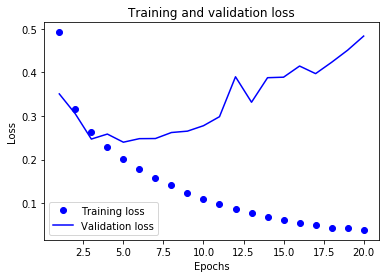

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

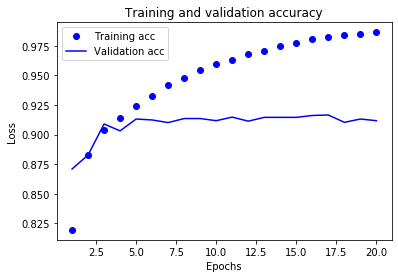

In [23]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
# save the model. We will visualize its intermediate activations in Result2
model.save("experiment3.h5")

## EXPERIMENT 3 (adding training/validation/testing generators) 

We redo `EXPERIMENT 3` but using training/validation/testing generators.

**N.B**: This part needs to be checked carefully...

## Building our network

We build a `CNN` containingg 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes.

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
# keras.utils.plot_model(model, show_shapes=True)

## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [26]:
# compile the model
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [27]:
train_images.shape

(55000, 28, 28, 1)

# Creating data generators

In [28]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
            train_images, 
            train_labels, 
            batch_size=100)

val_generator = test_datagen.flow(
            val_images, 
            val_labels, 
            batch_size=100)

In [29]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [30]:
for data_batch, labels_batch in val_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [31]:
train_images.shape, val_images.shape

((55000, 28, 28, 1), (5000, 28, 28, 1))

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [32]:
(len(train_images) /100),(len(val_images) /100)

(550.0, 50.0)

In [33]:
history = model.fit(
      train_generator,
      steps_per_epoch = len(train_images) /100,
      epochs= 20,
      validation_data= val_generator, 
      validation_steps = len(val_images) /100)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 550.0 steps, validate for 50.0 steps
Epoch 1/20
550/550 [==============================] - 48s 87ms/step - loss: 1.1691 - accuracy: 0.5838 - val_loss: 0.7177 - val_accuracy: 0.7382
Epoch 2/20
550/550 [==============================] - 47s 85ms/step - loss: 0.6833 - accuracy: 0.7398 - val_loss: 0.6107 - val_accuracy: 0.7820
Epoch 3/20
550/550 [==============================] - 47s 85ms/step - loss: 0.5932 - accuracy: 0.7758 - val_loss: 0.5241 - val_accuracy: 0.8098
Epoch 4/20
550/550 [==============================] - 47s 86ms/step - loss: 0.5314 - accuracy: 0.8005 - val_loss: 0.4947 - val_accuracy: 0.8178
Epoch 5/20
550/550 [==============================] - 47s 86ms/step - loss: 0.4858 - accuracy: 0.8190 - val_loss: 0.4834 - val_accuracy: 0.8180
Epoch 6/20
550/550 [==============================] - 47s 86ms/step - loss: 0.4520 - accuracy: 0.8303 - val_loss: 0.4137 - val_accuracy: 0.8456
Epoch 7/20
550/550 [===================

## EXPERIMENT 3 (Generator + data augmentation)

CNN with 2 convolution/max pooling layers (no drop out) with data augmatation.

**N.B**: This part needs to be checked carefully...

## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [34]:
# compile the model
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [35]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
x = train_images[0]
x = x.reshape((1,) + x.shape)
x.shape

(1, 28, 28, 1)

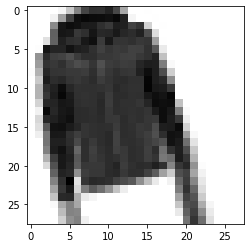

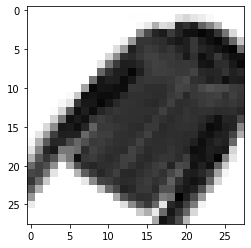

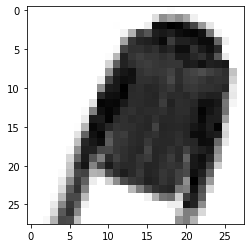

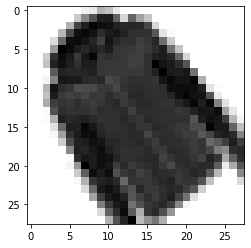

In [37]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='binary')
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [38]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
train_generator = train_datagen.flow(
            train_images, 
            train_labels, 
            batch_size=100)

val_generator = test_datagen.flow(
            val_images, 
            val_labels, 
            batch_size=100)

In [40]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [41]:
for data_batch, labels_batch in val_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [42]:
history = model.fit(
      train_generator,
      steps_per_epoch = len(train_images) /100,
      epochs= 20,
      validation_data= val_generator, 
      validation_steps = len(val_images) /100)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 550.0 steps, validate for 50.0 steps
Epoch 1/20
550/550 [==============================] - 54s 99ms/step - loss: 1.2101 - accuracy: 0.5574 - val_loss: 0.5060 - val_accuracy: 0.8130
Epoch 2/20
550/550 [==============================] - 54s 98ms/step - loss: 0.9465 - accuracy: 0.6520 - val_loss: 0.4943 - val_accuracy: 0.8142
Epoch 3/20
550/550 [==============================] - 54s 98ms/step - loss: 0.8639 - accuracy: 0.6813 - val_loss: 0.5011 - val_accuracy: 0.8196
Epoch 4/20
550/550 [==============================] - 54s 98ms/step - loss: 0.8211 - accuracy: 0.6968 - val_loss: 0.5064 - val_accuracy: 0.8126
Epoch 5/20
550/550 [==============================] - 54s 99ms/step - loss: 0.7907 - accuracy: 0.7056 - val_loss: 0.4673 - val_accuracy: 0.8356
Epoch 6/20
550/550 [==============================] - 54s 99ms/step - loss: 0.7624 - accuracy: 0.7147 - val_loss: 0.4619 - val_accuracy: 0.8352
Epoch 7/20
550/550 [===================

## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

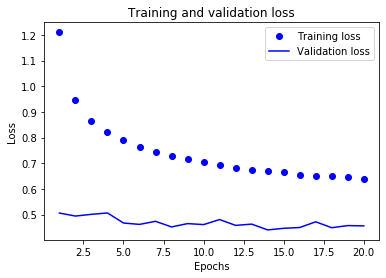

In [43]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

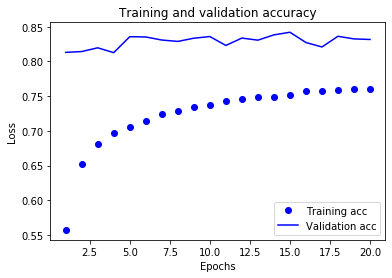

In [44]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [45]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 3s 310us/sample - loss: 1361.7453 - accuracy: 0.1277


[1361.7453123046876, 0.1277]

In [46]:
# save the model. We will visualize its intermediate activations in Result2
model.save("experiment3aug.h5")

## EXPERIMENT 4

We create a `CNN` with 3 convolution/max pooling layers (**no drop out**) to work with our Fashion MNIST dataset.

In [47]:
# CNN with 3 convolution/max pooling layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

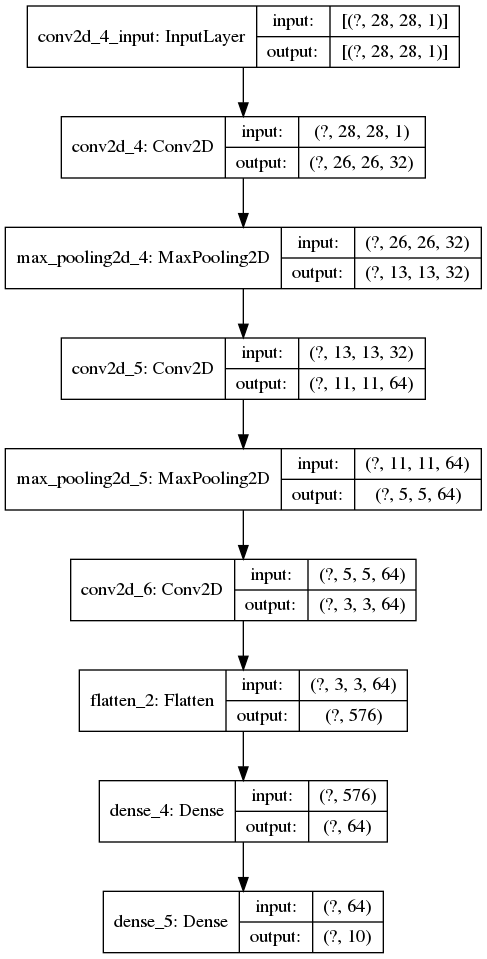

In [48]:
keras.utils.plot_model(model, show_shapes=True)

## Compiling the model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [49]:
# compile the model
model.compile(optimizer='rmsprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Training the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [50]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_images, train_labels, callbacks=[train_rt], epochs=20,  batch_size = 100,
                    validation_data=(val_images, val_labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 40s 728us/sample - loss: 0.6100 - accuracy: 0.7714 - val_loss: 0.3995 - val_accuracy: 0.8582
Epoch 2/20
55000/55000 [==============================] - 39s 707us/sample - loss: 0.3677 - accuracy: 0.8666 - val_loss: 0.3351 - val_accuracy: 0.8754
Epoch 3/20
55000/55000 [==============================] - 39s 709us/sample - loss: 0.3099 - accuracy: 0.8870 - val_loss: 0.2799 - val_accuracy: 0.9022
Epoch 4/20
55000/55000 [==============================] - 39s 711us/sample - loss: 0.2755 - accuracy: 0.8992 - val_loss: 0.2811 - val_accuracy: 0.8984
Epoch 5/20
55000/55000 [==============================] - 39s 713us/sample - loss: 0.2498 - accuracy: 0.9077 - val_loss: 0.2571 - val_accuracy: 0.9034
Epoch 6/20
55000/55000 [==============================] - 39s 717us/sample - loss: 0.2288 - accuracy: 0.9161 - val_loss: 0.2445 - val_accuracy: 0.9116
Epoch 7/20
55000/55000 [=====================

In [51]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

797.809766

In [52]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_images, test_labels, callbacks=[test_rt])

10000/10000 [==============================] - 3s 296us/sample - loss: 0.4016 - accuracy: 0.9059


In [ ]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

# Adding the statistics to our results DataFrame

We add the performance statistics for the new model to our DataFrame.

In [53]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10)

,loss,accuracy,val_loss,val_accuracy
10,0.154720,0.942291,0.240274,0.9166
11,0.144076,0.946582,0.252489,0.9138
12,0.132420,0.950855,0.263839,0.9146
13,0.123822,0.953764,0.261525,0.9212
14,0.114128,0.957727,0.289257,0.9156
15,0.106229,0.961236,0.328489,0.9100
16,0.098955,0.962964,0.292219,0.9138
17,0.092064,0.966382,0.318873,0.9186
18,0.085165,0.968727,0.340977,0.9122
19,0.080227,0.970273,0.375800,0.9078


In [55]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
results_df2 = history_df.iloc[-1:].copy()
results_df2.insert(0,'model','CNN (3 layers)') # went the model name to appear first
results_df2['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df2['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df2

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (3 layers),0.080227,0.970273,0.3758,0.9078,797.809766,3.18429


In [56]:
results_df=results_df.append(results_df2,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.454319,0.842818,0.471372,0.8414,33.794806,0.679247
1,DNN (3 layers),0.387822,0.864018,0.412587,0.8588,37.244016,0.731426
2,CNN (2 layers),0.038738,0.986491,0.483101,0.9118,941.517486,3.184290
3,CNN (3 layers),0.080227,0.970273,0.375800,0.9078,797.809766,3.184290


## Saving our DataFrame to disk

We pickle the DataFrame so that we keep adding to it Experiment 3.

In [57]:
results_df.to_pickle("results2.pkl") # save the DataFrame to use in Part 3

## Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

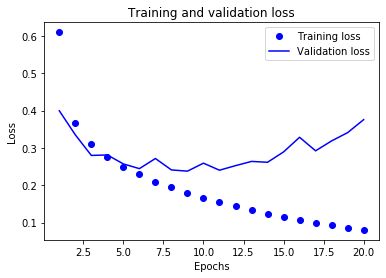

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

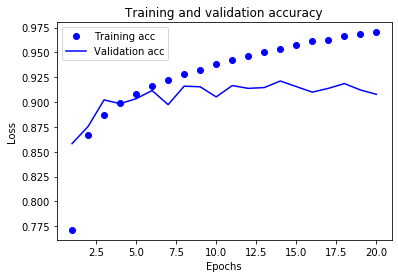

In [59]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()